<a href="https://colab.research.google.com/github/Hafeezali366/Plant-Disease-Detection-Using-Deep-Learning-CNN/blob/main/plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Detection Model

### 1. Import Libraries

In [ ]:
# Importing required libraries
import os
import zipfile
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Importing CNN models from Keras
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#### 1.1 Connect Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.2 Selecting Data from Dataset

In [ ]:
# Path to the zip file in Google Drive
dataset_zip_path = '/content/drive/MyDrive/Plant_dataset.zip'

# Extract the dataset from the zip file
zip_ref = zipfile.ZipFile(dataset_zip_path, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

# Defining the dataset path in program
data_dir = '/content/dataset/Plant_dataset'
train_dir = "/content/dataset/Plant_dataset/train"
val_dir = "/content/dataset/Plant_dataset/val"
test_dir = "/content/dataset/Plant_dataset/test"


In [ ]:
# Filter the dataset to use only the last 10 classes of Tomato leaves
def filter_classes(b_dir):
    """
    This function filters the dataset to retain only the last 10 classes.

    Args:
        b_dir (str): The base directory of the dataset part to filter.
    """
    # Get the last 10 class directories
    subdirs = sorted(os.listdir(b_dir))[-10:]
    # Iterate through directories
    for subdir in os.listdir(b_dir):
        # If the subdirectory is not in the last 10 classes
        if subdir not in subdirs:
            # Full path of the directory to remove
            f_path = os.path.join(b_dir, subdir)
            # Check if it is a directory
            if os.path.isdir(f_path):
                # Remove the directory and its contents
                os.system("rm -rf '{}'".format(f_path))

# Filter all the dataset parts by calling function
filter_classes(train_dir)
filter_classes(val_dir)
filter_classes(test_dir)


### 2. Data Visualization

In [ ]:
# Visualize dataset
def visualize_dataset(generator, title):
    """
    Visualizes a sample of images from a dataset generator.

    Args:
        generator (ImageDataGenerator): The dataset generator.
        title (str): Title for the visualization.
    """
    # Store labels for the dataset and images
    class_labels = list(generator.class_indices.keys())
    sample_images, sample_labels = next(generator)

    plt.figure(figsize=(10, 10))
    # Display 9 sample images using plt
    for i in range(9):
        plt.subplot(3, 3, i+1)
        # Display each image and label
        plt.imshow(sample_images[i])
        plt.title(class_labels[sample_labels[i].argmax()][:27])
        plt.axis('off')
    # Display main title
    plt.suptitle(title)
    plt.show()

# Print the dataset sample information
def show_dataset_info(generator, name):
    """
    Prints dataset information such as class names and sample count.

    Args:
        generator (ImageDataGenerator): The dataset generator.
        name (str): Name of the dataset.
    """
    print(f"{name} Dataset Information:")
    print(f"Number of Classes: {len(generator.class_indices)}")
    print(f"Classes: {list(generator.class_indices.keys())}")
    print(f"Number of Samples: {generator.samples}")
    print("-----------------------------------")


### 3. Data Preprocessing

In [ ]:
# Hyperparameters for training
img_size = (224, 224)
batch_size = 32
epochs = 10
learning_rate = 0.0001


In [ ]:
# Data augmentation for training images
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Create data generators
train_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

r = 1.0/255

val_gen = ImageDataGenerator(rescale=r).flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = ImageDataGenerator(rescale=r).flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 11296 images belonging to 10 classes.
Found 3768 images belonging to 10 classes.
Found 3771 images belonging to 10 classes.


Training Dataset Information:
Number of Classes: 10
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Number of Samples: 11296
-----------------------------------


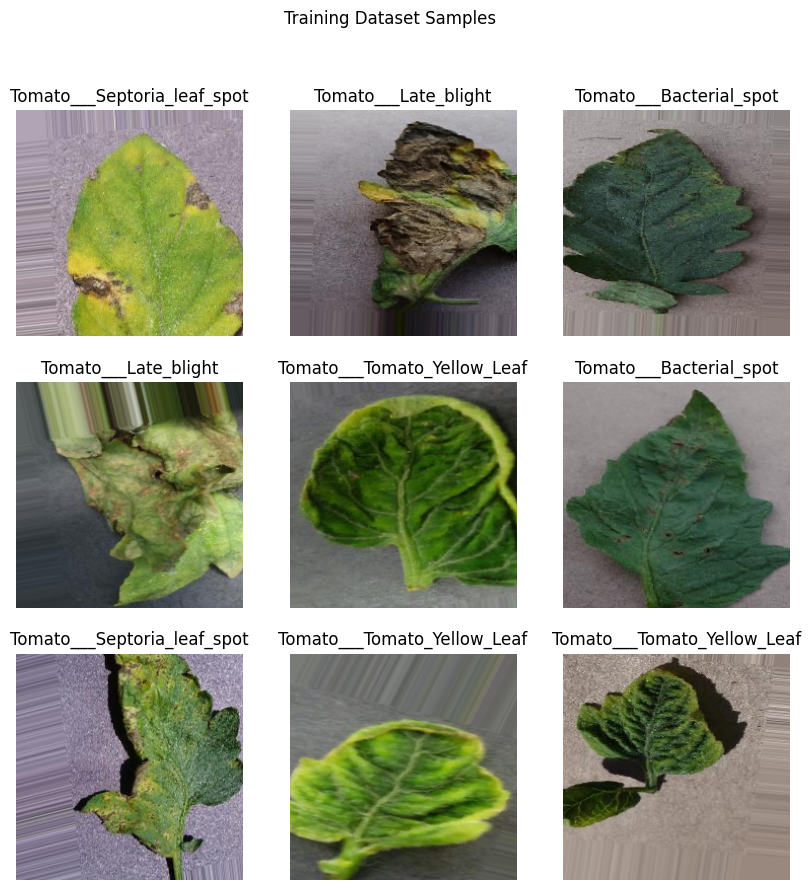

Validation Dataset Information:
Number of Classes: 10
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Number of Samples: 3768
-----------------------------------


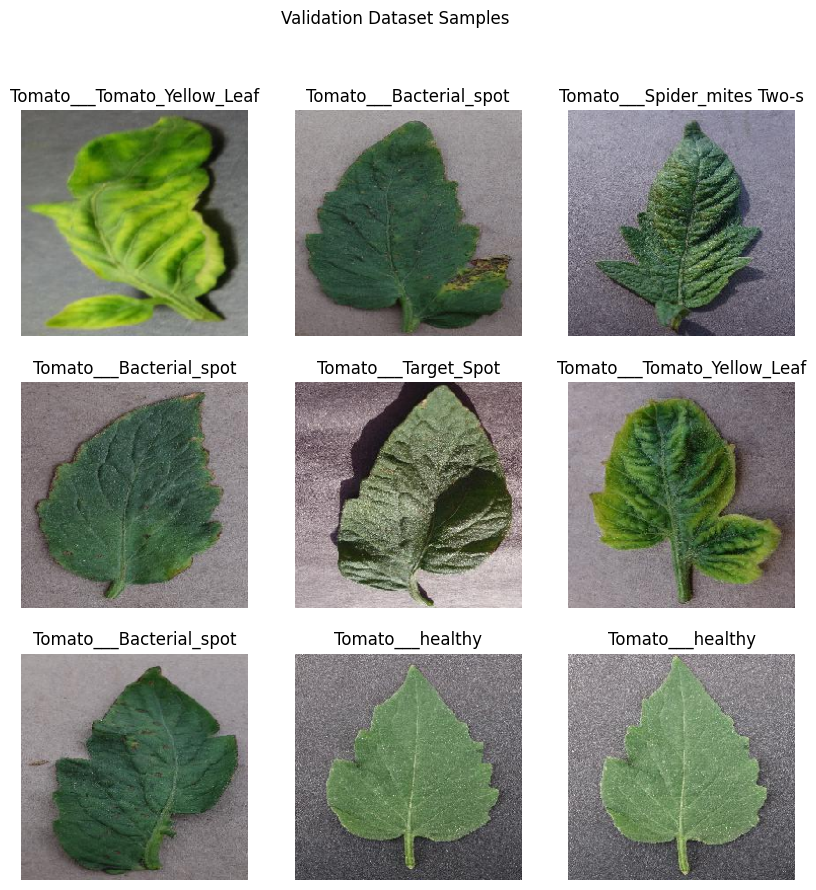

Testing Dataset Information:
Number of Classes: 10
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Number of Samples: 3771
-----------------------------------


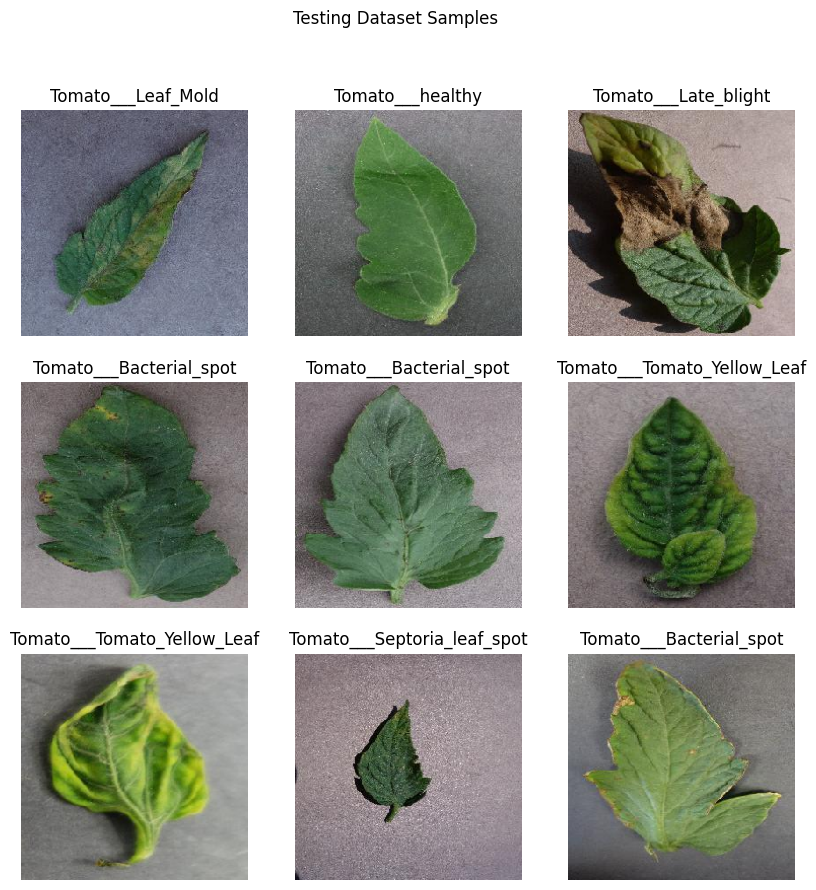

In [ ]:
# Show dataset information and visualize samples
show_dataset_info(train_gen, "Training")
visualize_dataset(train_gen, "Training Dataset Samples")

show_dataset_info(val_gen, "Validation")
visualize_dataset(val_gen, "Validation Dataset Samples")

show_dataset_info(test_gen, "Testing")
visualize_dataset(test_gen, "Testing Dataset Samples")

### 4. Model Training and Evaluation

#### 4.1 VGG16

In [ ]:
# Load the pre-trained VGG16 model without the top classification layers
vgg16_base = VGG16(weights='imagenet', include_top=False,
                   input_shape=(224, 224, 3))

# Freeze the convolutional base to retain pre-trained features
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom fully connected layers for fine-tuning
top_model = vgg16_base.output
top_model = Flatten()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(train_gen.num_classes, activation='softmax')(top_model)

# Combine the base model with the custom layers
model = Model(inputs=vgg16_base.input, outputs=top_model)


In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    # Suitable for multi-class classification
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Train the model
steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=epochs
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


353/353 ━━━━━━━━━━━━━━━━━━━━ 179s 487ms/step - accuracy: 0.4351 - loss: 1.7222 - val_accuracy: 0.7161 - val_loss: 0.9113
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7083 - val_loss: 0.9567
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 176s 491ms/step - accuracy: 0.6412 - loss: 1.0837 - val_accuracy: 0.7957 - val_loss: 0.6656
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.4556
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 200s 485ms/step - accuracy: 0.7038 - loss: 0.9017 - val_accuracy: 0.8237 - val_loss: 0.5806
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.3938
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 198s 486ms/step - accuracy: 0.7349 - loss: 0.8214 - val_accuracy: 0.8448 - val_loss: 0.5215
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.5683
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 195s 480ms/step - accuracy

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.8329 - loss: 0.5067
Test Accuracy: 83.29%


In [ ]:
def rep(lst):
    """
    Replaces zeros in a list with the mean of the preceding
    and succeeding values.
    """
    for i in range(len(lst)):
        if lst[i] == 0:
            if i == 0:
                lst[i] = lst[i + 1]
            elif i == len(lst) - 1:
                lst[i] = lst[i - 1]
            else:
                lst[i] = (lst[i - 1] + lst[i + 1]) / 2
    return lst

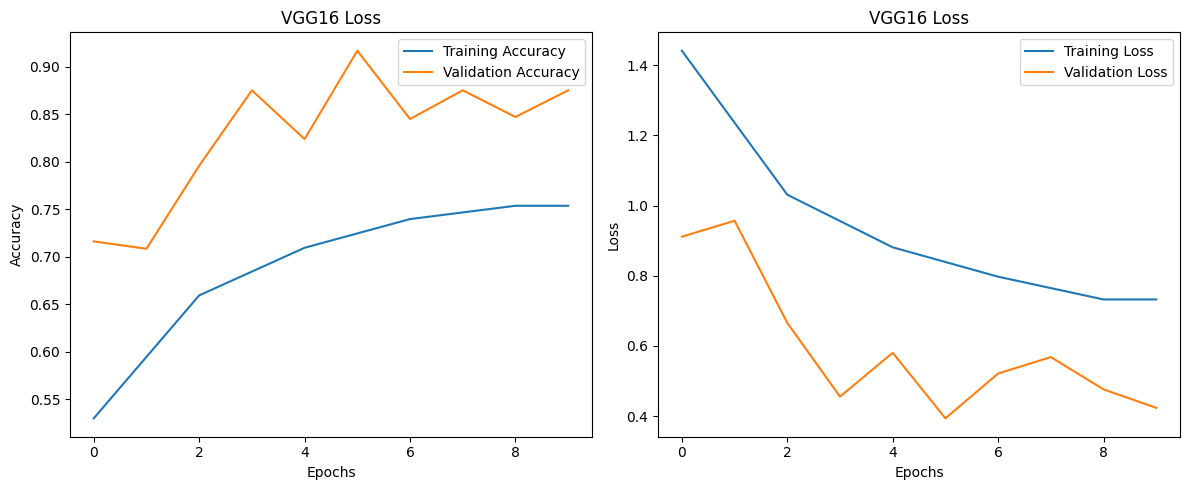

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(rep(history.history['accuracy']), label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(rep(history.history['loss']), label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step


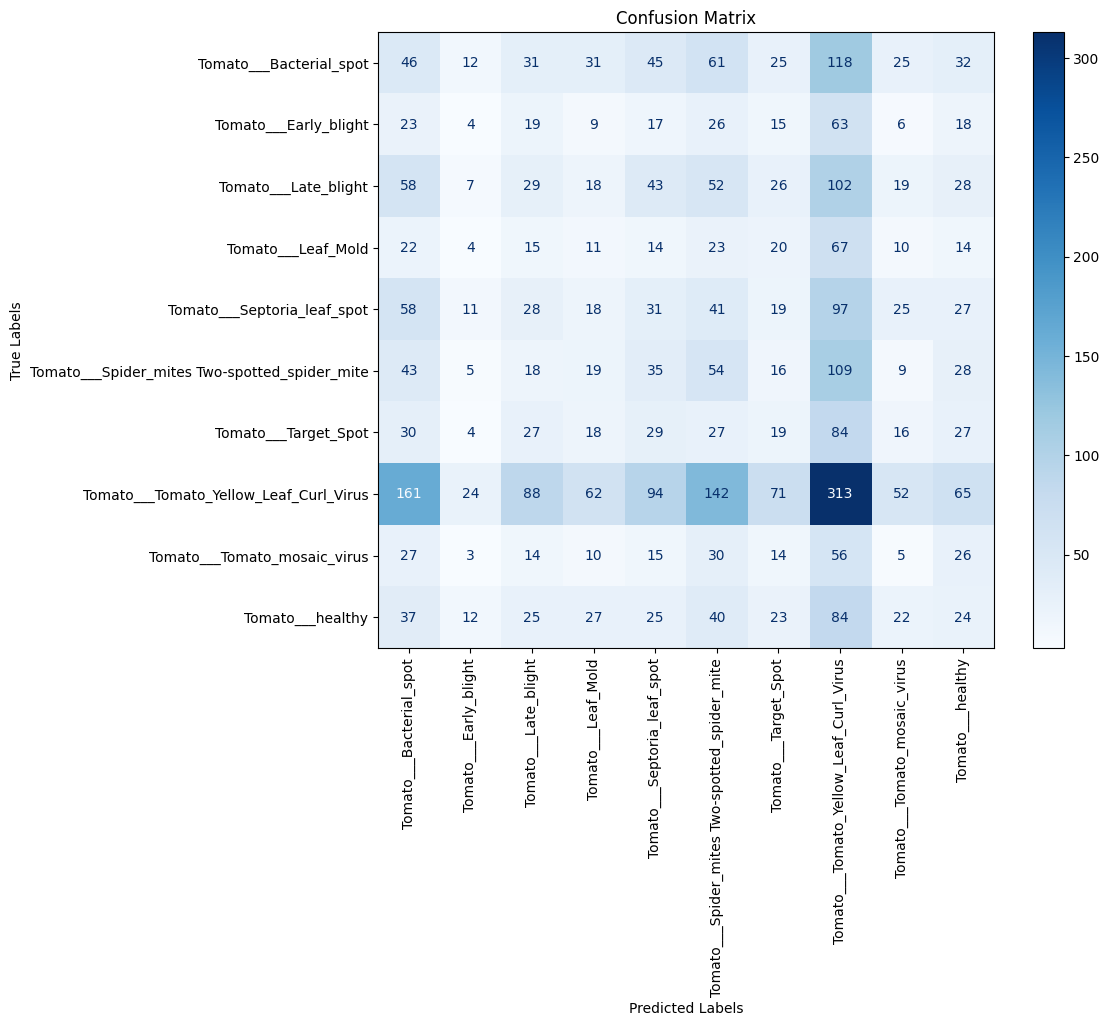

In [ ]:
# Generate predictions for the test set
pred = model.predict(test_gen)

# Convert predictions to class labels
pred_classes = np.argmax(pred, axis=1)

# True labels from the test set
true = test_gen.classes

# Class labels
class_labels = list(test_gen.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_labels).plot(cmap='Blues',
                            xticks_rotation='vertical', ax=plt.gca())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


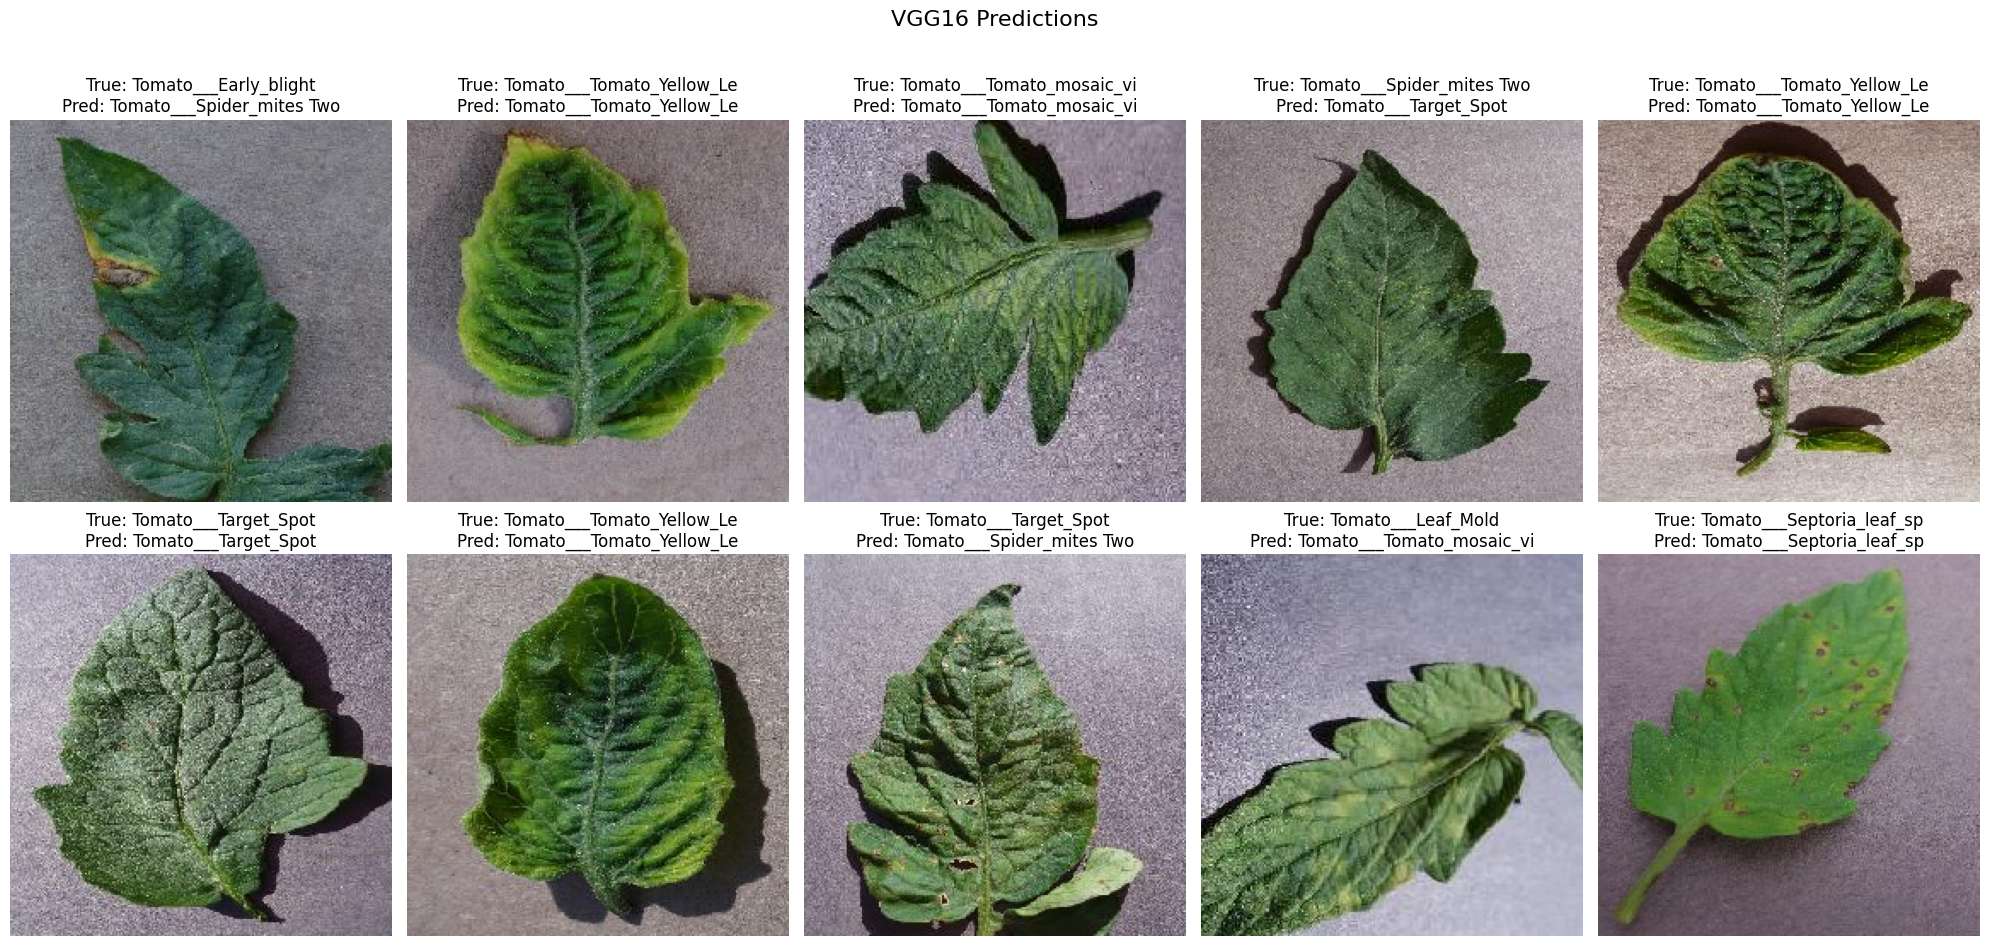

In [ ]:
# Get labels and image for test dataset
class_labels = list(test_gen.class_indices.keys())
sample_images, sample_labels = next(test_gen)

# Make prediction on the sample images
predictions = model.predict(sample_images)

plt.figure(figsize=(20, 10))
# Plot first 10 predicted image labels and true labels
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_labels[sample_labels[i].argmax()]
    predicted_label = class_labels[np.argmax(predictions[i])]
    plt.title(f"True: {true_label[:25]}\nPred: {predicted_label[:25]}")
    plt.axis('off')
plt.suptitle("VGG16 Predictions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### 4.2 RESNET50

In [ ]:
# Load the pre-trained ResNet50 model without the top classification layers
resnet50_base = ResNet50(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))

# Freeze all layers except the last 10
# This allows the model to retain the general features learned from ImageNet
for layer in resnet50_base.layers[:-10]:
    layer.trainable = False

# Fine-tune the last 10 layers of the ResNet50 model
# These layers will be updated during training to adapt to the new dataset
for layer in resnet50_base.layers[-10:]:
    layer.trainable = True

# Add custom layers on top of the ResNet50 base model
top_model = resnet50_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(train_gen.num_classes, activation='softmax')(top_model)

# Combine the base model with the custom layers
model = Model(inputs=resnet50_base.input, outputs=top_model)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    # Suitable for multi-class classification
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Train the model
steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=epochs
)


Epoch 1/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 181s 467ms/step - accuracy: 0.3497 - loss: 1.8813 - val_accuracy: 0.3699 - val_loss: 1.7703
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2083 - val_loss: 1.9632
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 163s 456ms/step - accuracy: 0.4893 - loss: 1.4701 - val_accuracy: 0.4172 - val_loss: 1.7420
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4583 - val_loss: 1.7318
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 163s 456ms/step - accuracy: 0.5441 - loss: 1.3508 - val_accuracy: 0.0972 - val_loss: 6.3389
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0833 - val_loss: 7.3077
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 166s 457ms/step - accuracy: 0.5647 - loss: 1.2665 - val_accuracy: 0.2463 - val_loss: 2.9047
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.2021
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 165s 456ms/step - accura

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.4915 - loss: 2.1359
Test Accuracy: 49.35%


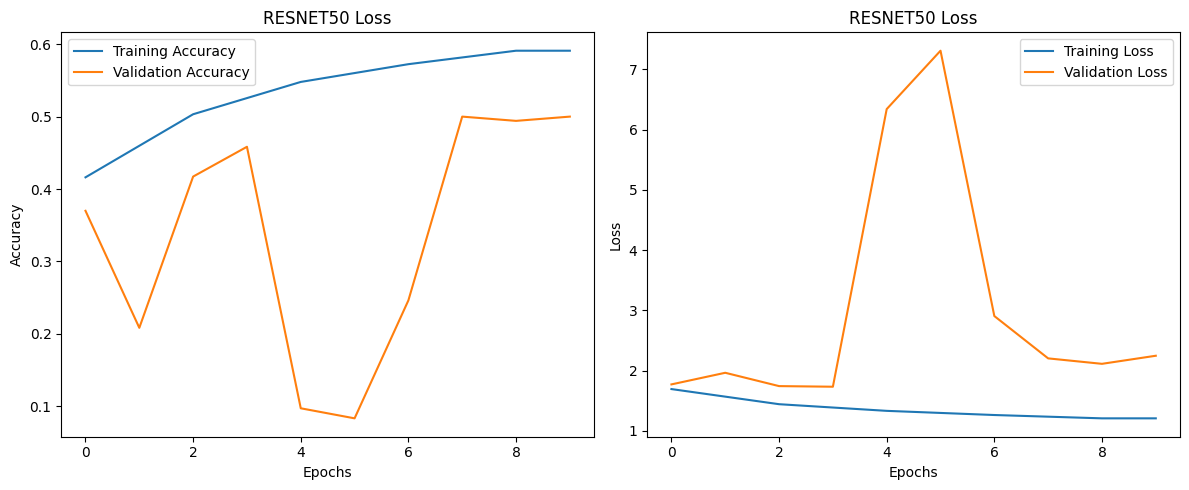

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(rep(history.history['accuracy']), label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RESNET50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(rep(history.history['loss']), label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RESNET50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step


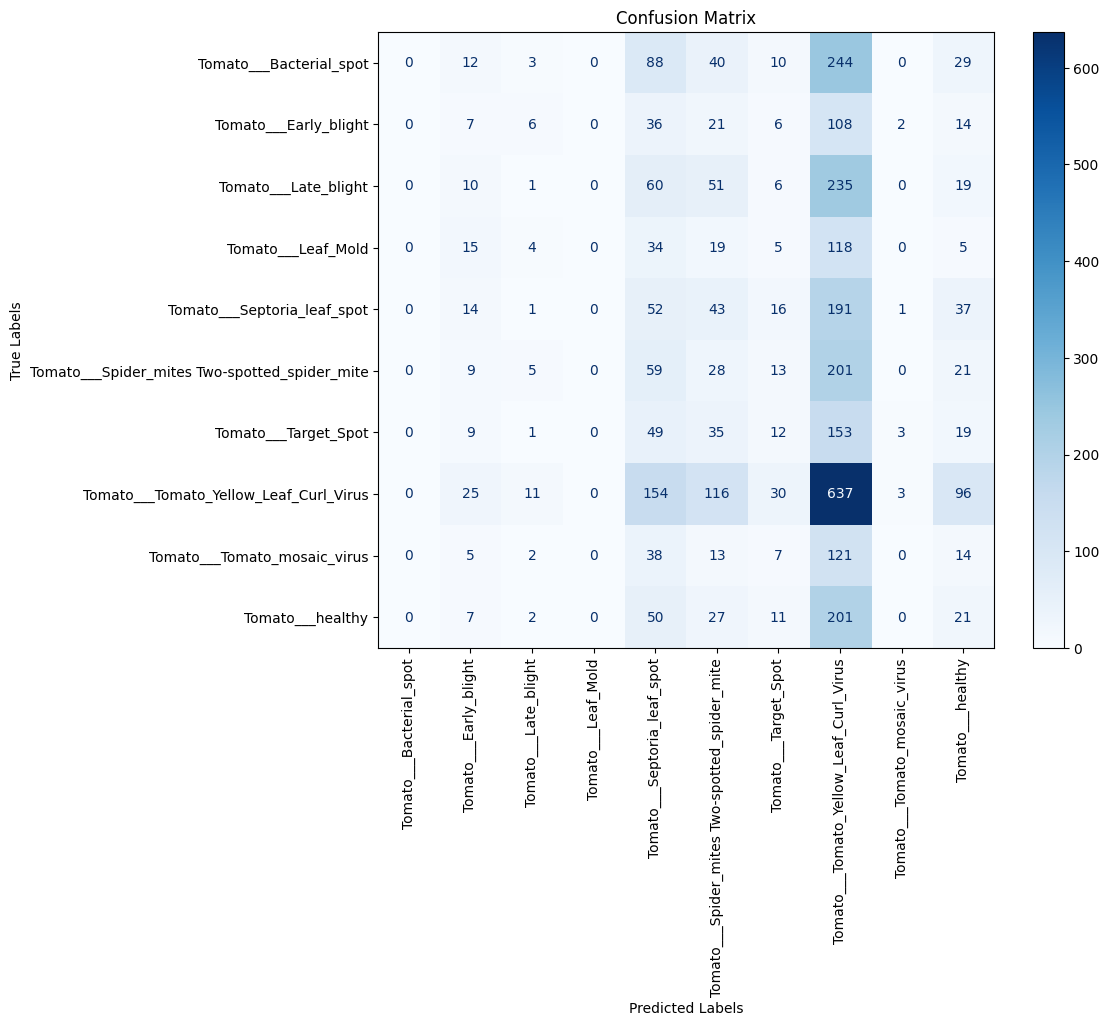

In [ ]:
# Generate predictions for the test set
pred = model.predict(test_gen)

# Convert predictions to class labels
pred_classes = np.argmax(pred, axis=1)

# True labels from the test set
true = test_gen.classes

# Class labels
class_labels = list(test_gen.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_labels).plot(cmap='Blues',
                            xticks_rotation='vertical', ax=plt.gca())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


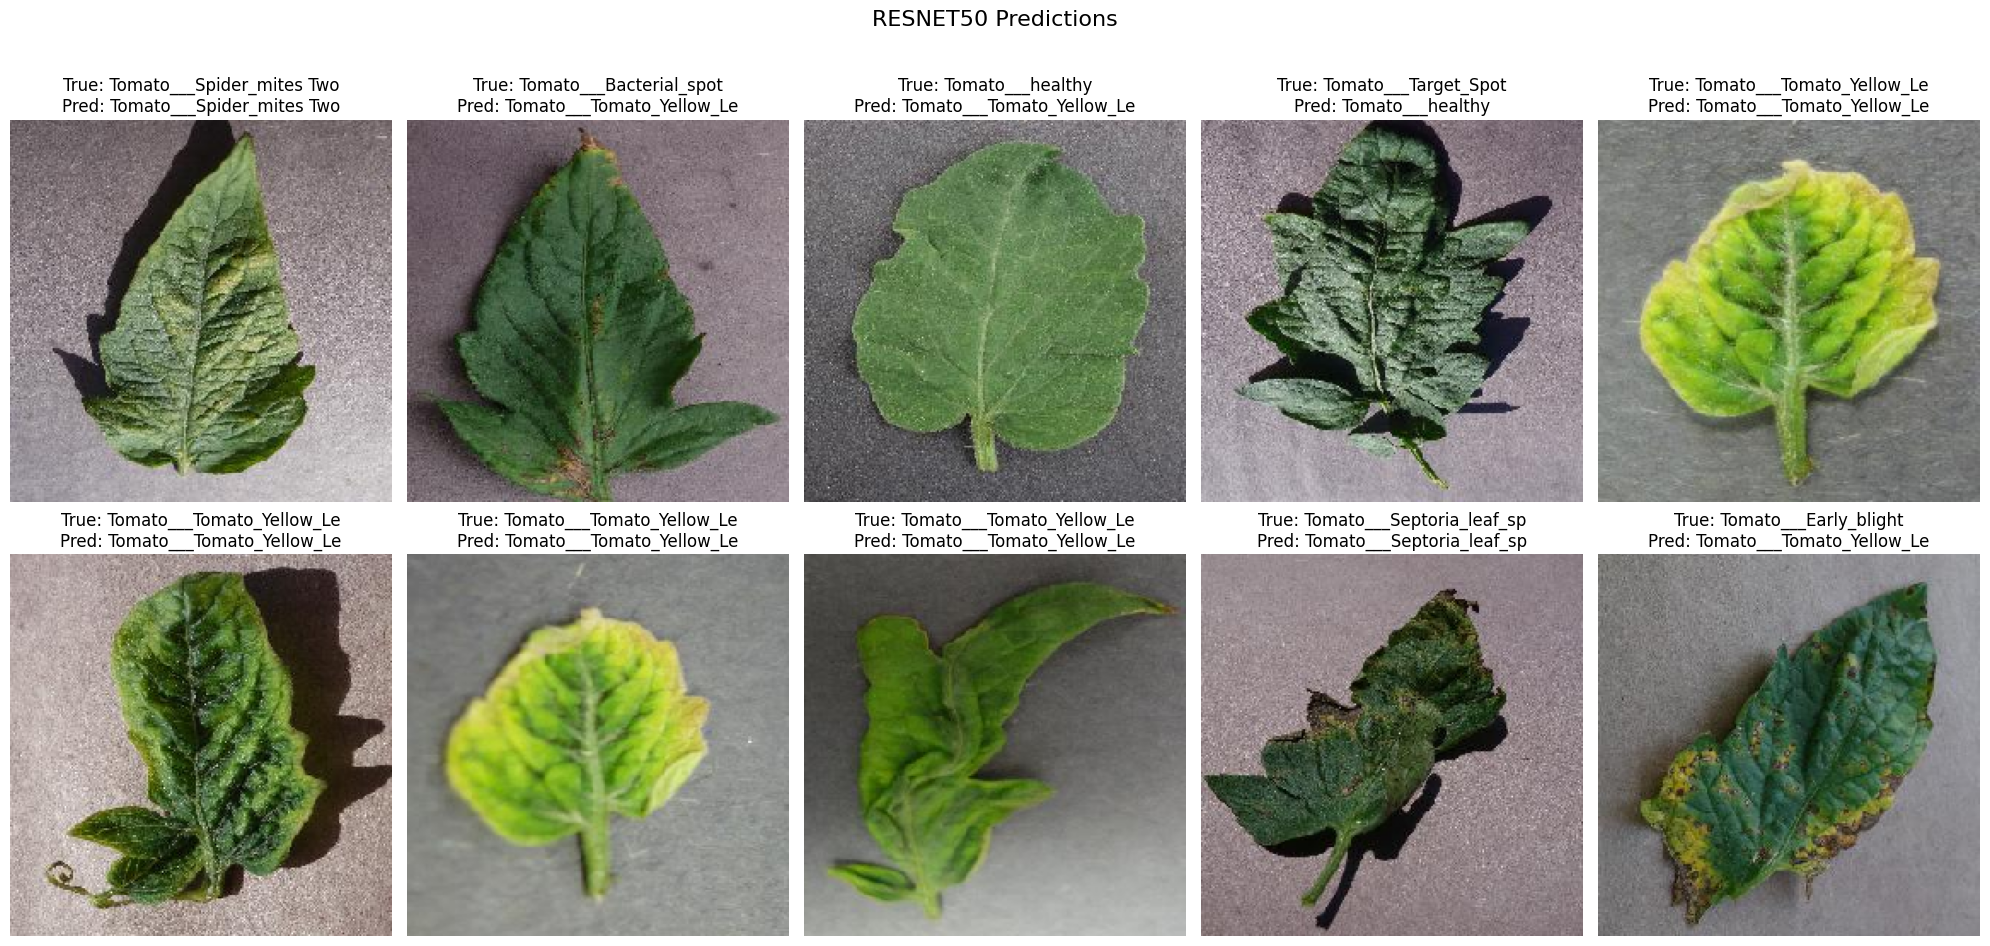

In [ ]:
# Get labels and image for test dataset
class_labels = list(test_gen.class_indices.keys())
sample_images, sample_labels = next(test_gen)

# Make prediction on the sample images
predictions = model.predict(sample_images)

plt.figure(figsize=(20, 10))
# Plot first 10 predicted image labels and true labels
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_labels[sample_labels[i].argmax()]
    predicted_label = class_labels[np.argmax(predictions[i])]
    plt.title(f"True: {true_label[:25]}\nPred: {predicted_label[:25]}")
    plt.axis('off')
plt.suptitle("RESNET50 Predictions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()